<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/Maximization_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Maximization Bias in Q Learning

This is an example of the markov random process Example 6.7 in page-134 from the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

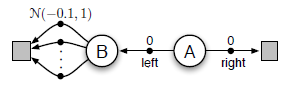

In [ ]:
nodes = 4
actions = [-1,1]
num_actions = 2
start = 2

In [ ]:
def gaussian_reward():
  return np.random.normal(-0.1,1)

def target_policy(Q,current):
  maxQ = np.max(Q[current,:])
  idx = np.where(Q[current,:] == maxQ)[0]
  return np.random.choice(idx)

def step(current,action):
  next_state = current + a
  reward = 0
  if next_state == 0:
    reward = gaussian_reward()
  return next_state,reward 

def play(num_episodes,alpha,epsilon,gamma):
  Q = np.zeros((nodes,num_actions))
  for episode in num_episodes:
    current = start
    while current in [1,2]:
      act_idx = target_policy(Q,current)
      a = actions[act_idx]
      next_state,reward = step(current,a)
      Q[current,a] += alpha*(reward + gamma*np.max(Q[next_state,:]) - Q[current,a])
  return stats





-0.09684517002352125


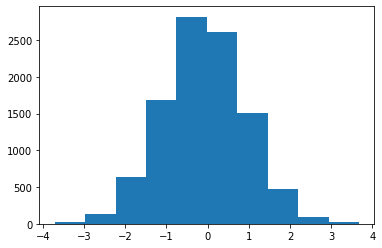

In [5]:
x = []
for i in range(10000):
  x.append(np.random.normal(-0.1,1))
plt.hist(x)

print(np.median(x))